1.1 importación de librerias

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, validation_curve

1.2 ajuste de formato de datos


In [157]:
path = '../resources/etapa_2/datos_etapa_2.csv'
with open(path, 'r') as file:
    content = file.read()

content = content.replace('"', '')  # Eliminar las comillas dobles

with open(path, 'w') as file:
    file.write(content)

1.3 Carga de datos

In [158]:
data_original = pd.read_csv(path, sep=',')
data_copy = data_original.copy() 
data_copy.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,NO
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,NO
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,NO
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,NO
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,NO


1.4 Exploración del conjunto de Datos

In [159]:
data_copy.describe()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000
mean,7.080804,196.369481,22014.092415,7.122241,333.775784,426.205171,14.284921,66.396281,3.966731
std,1.594369,32.879680,8768.570852,1.583143,41.416864,80.824123,3.308232,16.174983,0.780354
min,0.000000,47.430000,320.940000,0.350000,129.000000,181.480000,2.200000,0.740000,1.450000
25%,6.090000,176.847500,15666.687500,6.130000,307.695000,365.735000,12.070000,55.847500,3.440000
50%,7.040000,196.965000,20927.830000,7.130000,333.070000,421.885000,14.220000,66.620000,3.955000
75%,8.060000,216.670000,27332.760000,8.112500,359.950000,481.790000,16.560000,77.337500,4.500000
max,14.000000,323.120000,61227.200000,13.130000,481.030000,753.340000,28.300000,124.000000,6.740000


1.5 Se realiza la revisión de los datos incompletos, se obtiene
los siguientes resultados:  

In [160]:
print("duplicados: ", data_copy.duplicated().sum())

duplicados:  0


1.6 Datos incompletos <br>
Se hace revisión de los valores nulos y se contrasta con la cantidad de registros
totales. Al ser una cantidad significativa de registros los cuales les presentan ausencia de datos
se decide hacer imputación y no eliminar los registos, asi como tampoco eliminar ninguna columna. 

In [161]:
total_faltantes = data_copy.isnull().sum()
porcentaje_faltante = total_faltantes / len(data_copy)
tabla = list(zip(data_copy.columns,total_faltantes, porcentaje_faltante))
tabla = pd.DataFrame(tabla, columns=['columns', 'total_faltantes', 'porcentaje'])
print(tabla)

            columns  total_faltantes  porcentaje
0                pH              491    0.149878
1            Dureza                0    0.000000
2           Sólidos                0    0.000000
3        Cloraminas                0    0.000000
4          Sulfatos              781    0.238400
5     Conductividad                0    0.000000
6  Carbono_orgánico                0    0.000000
7    Trihalometanos              162    0.049451
8          Turbidez                0    0.000000
9       Potabilidad                0    0.000000


1.7 Variable Categóricas <br>
Se evidencia una variable categórica llamada "Potabilidad", dicha variable es binaria "si" o "no"
a lo cual se opta por implementar un LaberEncoder para asignar 1 o 0 según sea "si" o "no"

In [162]:
label_encoder = LabelEncoder()
data_copy['Potabilidad'] = label_encoder.fit_transform(data_copy['Potabilidad'])
data_copy.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,0
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,0
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,0
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,0
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,0


1.8 Equilibrio de datos <br>
Se verifica el balance de los datos respecto a la variable objetivo "si" o "no", al haber un desbalance en los datos se decide implementar el class_weight = 'balanced' para evitar un sesgo en los resultados

In [163]:
data_total = data_original['Potabilidad'].value_counts()
data_percent = data_total / len(data_original)
data_tabla = list(zip(['no', 'si'],data_total,data_percent))
data_tabla = pd.DataFrame(data_tabla, columns=['Potable','columns', 'data_percent'])
print(data_tabla)

  Potable  columns  data_percent
0      no     1998       0.60989
1      si     1278       0.39011


1.9 Matriz de correlación <br>
como se puede observar en la siguiente matriz de correlación, no existe una linealidad directa entre las variables independientes y la variable objetivo. Adicionalmente no se evidencia una colinealidad entre las variables por lo cual se decide no eliminar ninguna variable.

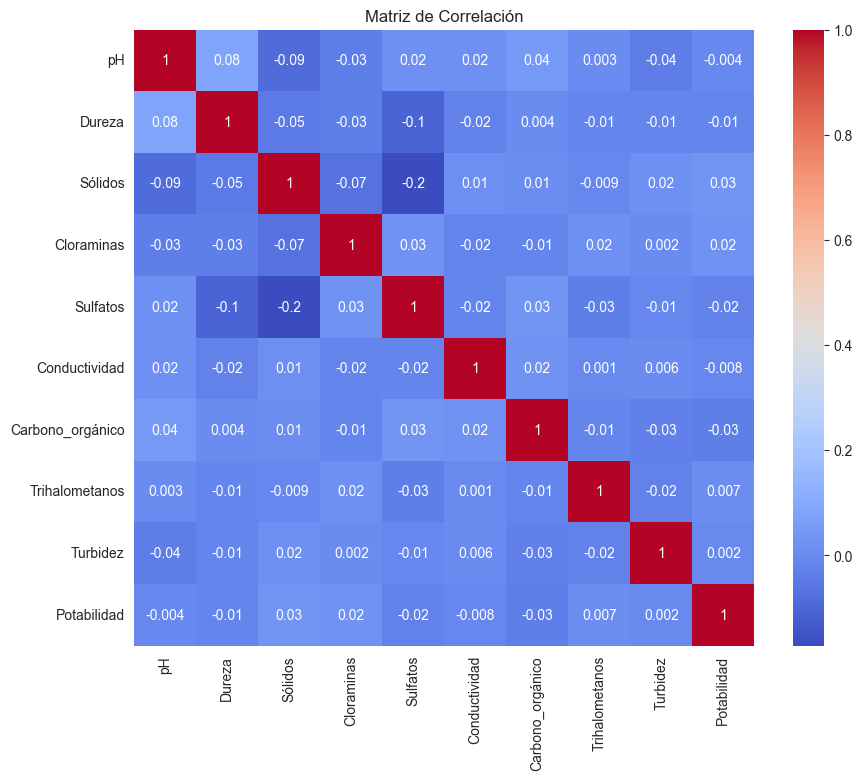

In [164]:
correlation_matrix = data_copy.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".1g", cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

2.0 Separacion datos de entrenamiento y test <br>
Se hace la separación del conjunto de datos

In [165]:
train, test = train_test_split(data_copy, test_size=0.2, random_state= 77)
print( train.shape, test.shape)

(2620, 10) (656, 10)


2.1 Separación de la variable dependiente

In [166]:
x_train = train.drop(['Potabilidad'], axis=1)
y_train = train['Potabilidad']
print(x_train.shape, y_train.shape)

(2620, 9) (2620,)


CONSTRUCCIÓN ARBOL DE DECISIÓN <br>
2.2 definición algoritmo de búsqueda y el imputer

In [167]:
imputer = SimpleImputer(strategy='mean')
decision_tree = DecisionTreeClassifier(random_state= 77, class_weight='balanced')

2.3 Creación del pipeline <br>
se crea el pipeline, sin embargo, para este caso al ser un arbol de decisión no se implementará ningún tipo de scaler

In [168]:
steps = [
    ('imputer', imputer),
    ('model', decision_tree),
]
pipeline = Pipeline(steps)

2.4 Búsqueda de hiperparámetros

In [169]:
param_grid = {
    'imputer__strategy': ['mean', 'median'],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [4, 6, 8, 10, 12],
    'model__min_samples_split': [3, 4, 5],
}
kfold = KFold(n_splits=5, random_state=77, shuffle=True)
grid = GridSearchCV(pipeline, param_grid, cv=kfold, n_jobs=-1)
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('model',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=77))]),
             n_jobs=-1,
             param_grid={'imputer__strategy': ['mean', 'median'],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [4, 6, 8, 10, 12],
                         'model__min_samples_split': [3, 4, 5]})

In [170]:
print(grid.best_params_)

{'imputer__strategy': 'mean', 'model__criterion': 'gini', 'model__max_depth': 8, 'model__min_samples_split': 5}


In [171]:
mejor_modelo = grid.best_estimator_

In [172]:
importacia = mejor_modelo['model'].feature_importances_
importancia_imputada = pd.DataFrame(data = {'Variable': x_train.columns, 'Importanca': importacia} )
importancia_imputada.sort_values('Importanca', ascending=False)

,Variable,Importanca
0,pH,0.237330
4,Sulfatos,0.147812
5,Conductividad,0.133766
6,Carbono_orgánico,0.104615
2,Sólidos,0.096296
3,Cloraminas,0.090413
1,Dureza,0.079363
8,Turbidez,0.060580
7,Trihalometanos,0.049824


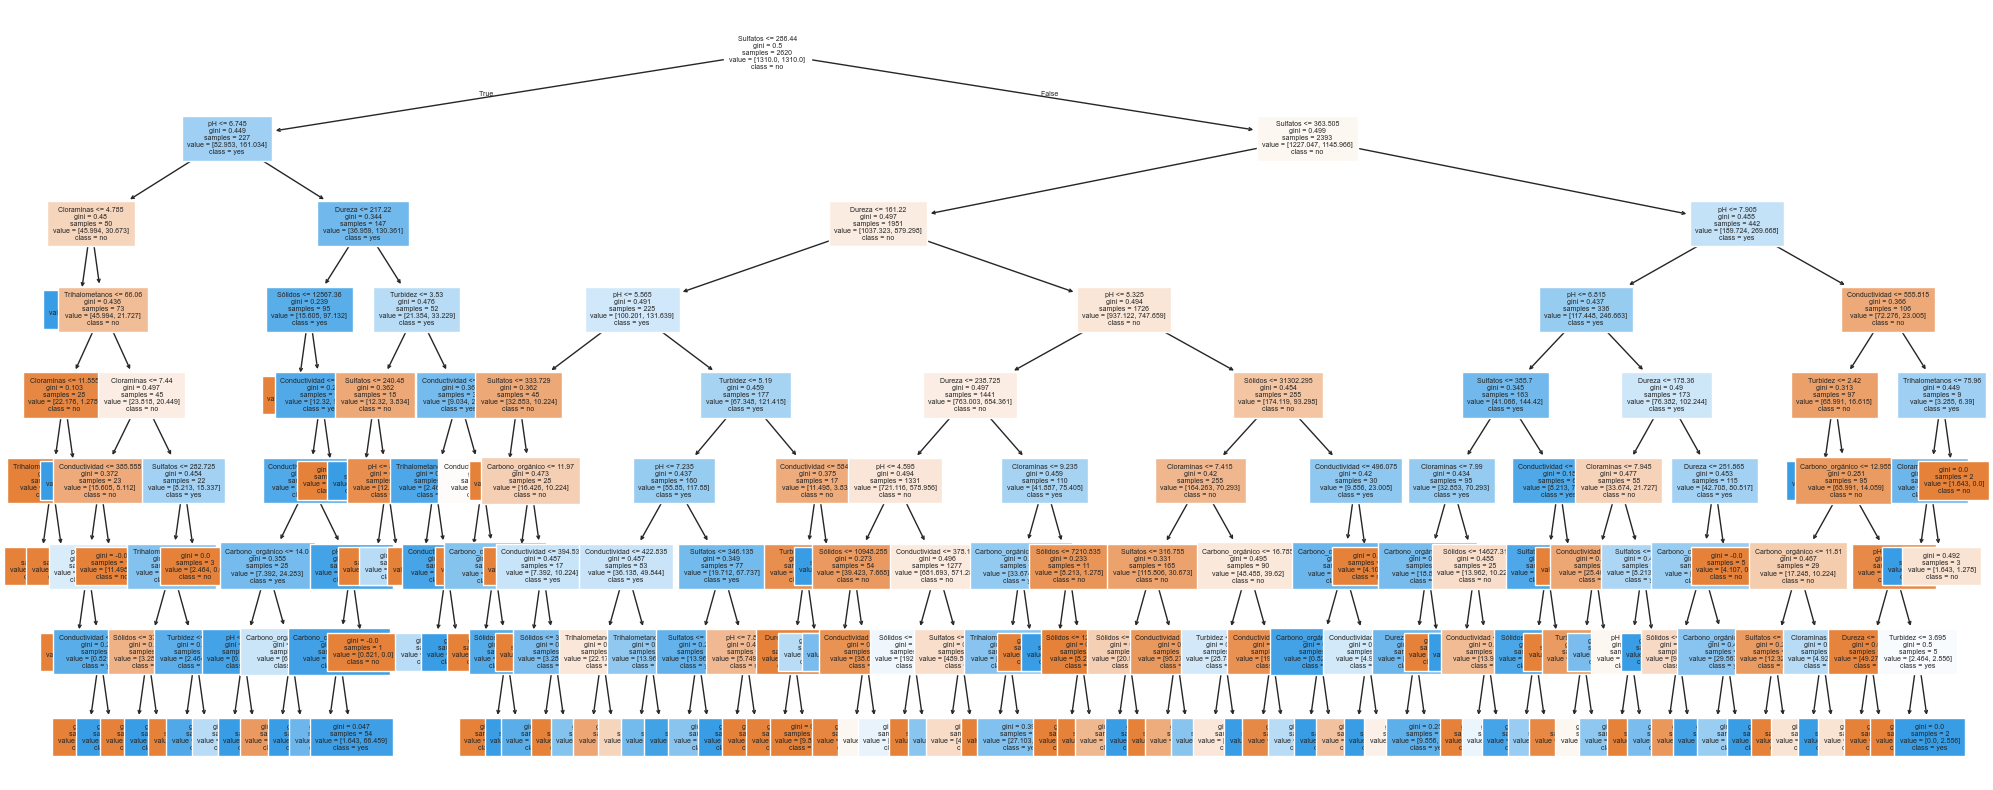

In [173]:
plt.figure(figsize= (25,10))
three = plot_tree(mejor_modelo['model'], feature_names=x_train.columns, class_names = ['no', 'yes'], filled = True, fontsize = 5)

Evaluación del modelo

2.5 Separación variable independiente 

In [174]:
x_test = test.drop(['Potabilidad'], axis=1)
y_test = test['Potabilidad']
print(x_test.shape, y_test.shape)

(656, 9) (656,)


In [175]:
y_pred = mejor_modelo.predict(x_test)

[[284 119]
 [136 117]]


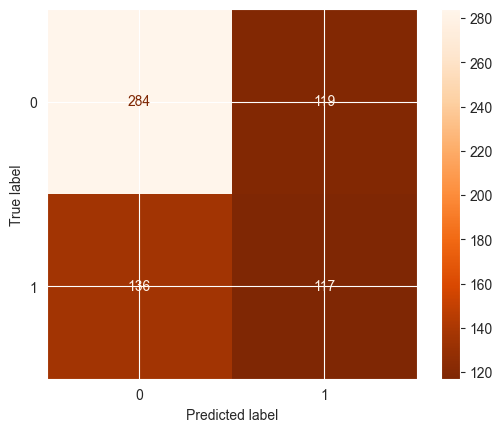

In [176]:
cm_tree = confusion_matrix(y_test, y_pred)
print(cm_tree)
cmd_tree = ConfusionMatrixDisplay(cm_tree)
cmd_tree.plot(colorbar= True, include_values= True, cmap= 'Oranges_r', ax= None)

In [177]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       403
           1       0.50      0.46      0.48       253

    accuracy                           0.61       656
   macro avg       0.59      0.58      0.58       656
weighted avg       0.61      0.61      0.61       656



Construcción KNN <br>
2.6 Estandarización de los datos

In [178]:
x_train.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez
3126,6.67,155.71,30610.05,8.17,337.17,425.69,15.10,79.78,4.90
3147,6.26,130.37,9734.68,10.28,320.36,399.35,10.85,43.42,3.93
2844,6.66,182.39,16828.88,7.07,355.90,434.66,16.62,69.41,3.97
1916,8.02,255.26,30854.83,8.76,NaN,442.50,11.09,93.27,5.32
1053,8.92,207.52,13291.92,8.56,357.94,468.54,15.69,107.28,4.08


In [179]:
columns = x_train.columns
imputer = SimpleImputer(missing_values=np.nan, strategy= 'median')
scaler_knn = RobustScaler()

In [180]:
x_train_knn = x_train.copy()
x_train_knn = pd.DataFrame(imputer.fit_transform(x_train), columns= columns)
x_train_knn = pd.DataFrame(scaler_knn.fit_transform(x_train_knn), columns= columns)
print(x_train_knn.isna().sum())
x_train_knn.head()

pH                  0
Dureza              0
Sólidos             0
Cloraminas          0
Sulfatos            0
Conductividad       0
Carbono_orgánico    0
Trihalometanos      0
Turbidez            0
dtype: int64


,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez
0,-0.23750,-1.019346,0.818072,0.526582,0.118937,0.043629,0.197088,0.668418,0.905660
1,-0.49375,-1.639892,-0.944526,1.594937,-0.385944,-0.179515,-0.754759,-1.150719,-0.009434
2,-0.24375,-0.365985,-0.345532,-0.030380,0.681484,0.119620,0.537514,0.149593,0.028302
3,0.60625,1.418514,0.838739,0.825316,0.000000,0.186039,-0.701008,1.343340,1.301887
4,1.16875,0.249418,-0.644173,0.724051,0.742754,0.406642,0.329227,2.044278,0.132075


In [181]:
x_test_knn = x_test.copy()
x_test_knn = pd.DataFrame(imputer.fit_transform(x_test), columns= columns)
x_test_knn = pd.DataFrame(scaler_knn.fit_transform(x_test_knn), columns= columns)
print(x_test_knn.isna().sum())
x_test_knn.head()

pH                  0
Dureza              0
Sólidos             0
Cloraminas          0
Sulfatos            0
Conductividad       0
Carbono_orgánico    0
Trihalometanos      0
Turbidez            0
dtype: int64


,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez
0,0.101639,-0.602416,-0.156137,-0.297650,1.232562,-1.253409,-1.509209,1.065319,-0.550117
1,1.885246,0.354515,1.297015,0.652742,0.156412,0.317724,-0.893824,-0.803056,0.494172
2,0.272131,-0.475462,-0.736402,0.381201,0.000000,-0.490832,0.839653,-1.320187,-0.130536
3,1.898361,0.764862,0.775072,0.323760,-1.552087,-0.681805,-0.007584,0.829677,0.699301
4,0.000000,-2.370760,-0.595658,-0.887728,-1.549650,0.785520,0.167931,0.960808,-0.083916


In [182]:
k_values = np.linspace(1, 5, 5, dtype = 'int64')
k_values 

array([1, 2, 3, 4, 5])

In [183]:
train_scores, val_scores = validation_curve(estimator=KNeighborsClassifier(),
                                            X=x_train_knn,
                                            y=y_train,
                                            param_name='n_neighbors',
                                            param_range=k_values,
                                            scoring='accuracy',
                                            #class_weight='balanced', # OJO: Revisar este parámetro
                                            cv=10)

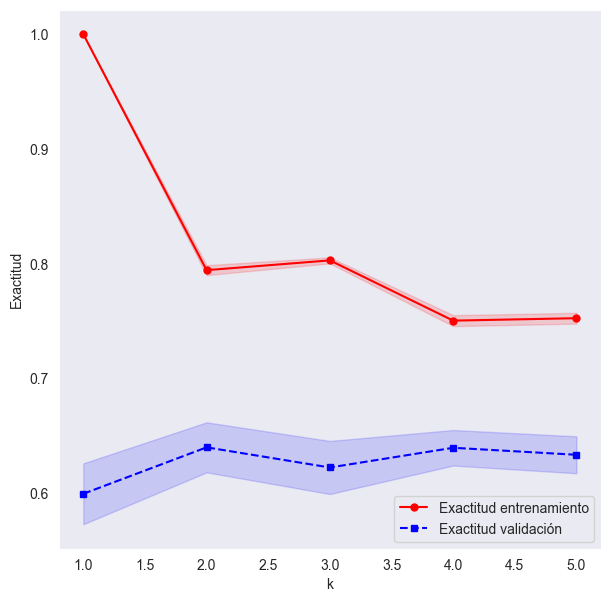

In [184]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)
#Inicialización de la figura
plt.figure(figsize=(7,7))

#curva de validación 
plt.plot(k_values, train_mean, color='red', marker='o', markersize=5, label='Exactitud entrenamiento')
plt.fill_between(k_values, train_mean + train_std, train_mean-train_std, alpha=0.15, color='red')

#curva de validación para el conjunto de validación
plt.plot(k_values, val_mean, color='blue', linestyle='--', marker='s', markersize=5, label='Exactitud validación')
plt.fill_between(k_values, val_mean+val_std, val_mean-val_std, alpha=0.15, color='blue')

#Grilla y etiquetas
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('k')
plt.ylabel('Exactitud')
plt.show()

In [185]:
mejor_valor = np.argmax(val_mean)
mejor_valor

np.int64(1)

In [186]:
mejor_k = k_values[mejor_valor]
mejor_k

np.int64(2)

In [187]:
mejor_modelo = KNeighborsClassifier(n_neighbors=mejor_k).fit(x_train_knn, y_train)

In [188]:
y_pred_knn = mejor_modelo.predict(x_test_knn)

[[363  40]
 [191  62]]


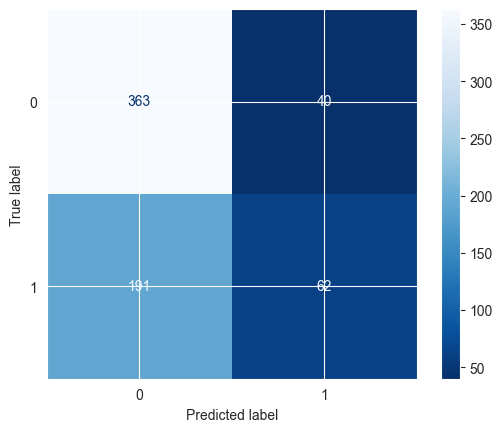

In [189]:
cm_tree = confusion_matrix(y_test, y_pred_knn)
print(cm_tree)
cmd_tree = ConfusionMatrixDisplay(cm_tree)
cmd_tree.plot(colorbar= True, include_values= True, cmap= 'Blues_r', ax= None)

In [190]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.66      0.90      0.76       403
           1       0.61      0.25      0.35       253

    accuracy                           0.65       656
   macro avg       0.63      0.57      0.55       656
weighted avg       0.64      0.65      0.60       656



In [191]:
print("arboles de decisión")
print(classification_report(y_test, y_pred))
print("knn")
print(classification_report(y_test, y_pred_knn))

arboles de decisión
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       403
           1       0.50      0.46      0.48       253

    accuracy                           0.61       656
   macro avg       0.59      0.58      0.58       656
weighted avg       0.61      0.61      0.61       656

knn
              precision    recall  f1-score   support

           0       0.66      0.90      0.76       403
           1       0.61      0.25      0.35       253

    accuracy                           0.65       656
   macro avg       0.63      0.57      0.55       656
weighted avg       0.64      0.65      0.60       656



ARBOL DE DECISIÓN DE PROFUNDIDAD 3

In [192]:
new_param_grid = {
    'imputer__strategy': ['mean', 'median'],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3],
    'model__min_samples_split': [3, 4, 5],
}
new_grid = GridSearchCV(pipeline, new_param_grid, cv= kfold, n_jobs= -1)
new_grid.fit(x_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('model',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=77))]),
             n_jobs=-1,
             param_grid={'imputer__strategy': ['mean', 'median'],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3],
                         'model__min_samples_split': [3, 4, 5]})

In [193]:
print("mejores parametros obtenidos: {}".format(new_grid.best_params_))

mejores parametros obtenidos: {'imputer__strategy': 'mean', 'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_split': 3}


In [194]:
new_mejor_modelo = new_grid.best_estimator_
new_importancia = new_mejor_modelo['model'].feature_importances_
new_importancia_df = pd.DataFrame(data = {'Nombre':columns, 'Importancia': new_importancia})
new_importancia_df.sort_values('Importancia', ascending = False)

,Nombre,Importancia
4,Sulfatos,0.474490
0,pH,0.252436
2,Sólidos,0.154587
1,Dureza,0.118486
3,Cloraminas,0.000000
5,Conductividad,0.000000
6,Carbono_orgánico,0.000000
7,Trihalometanos,0.000000
8,Turbidez,0.000000


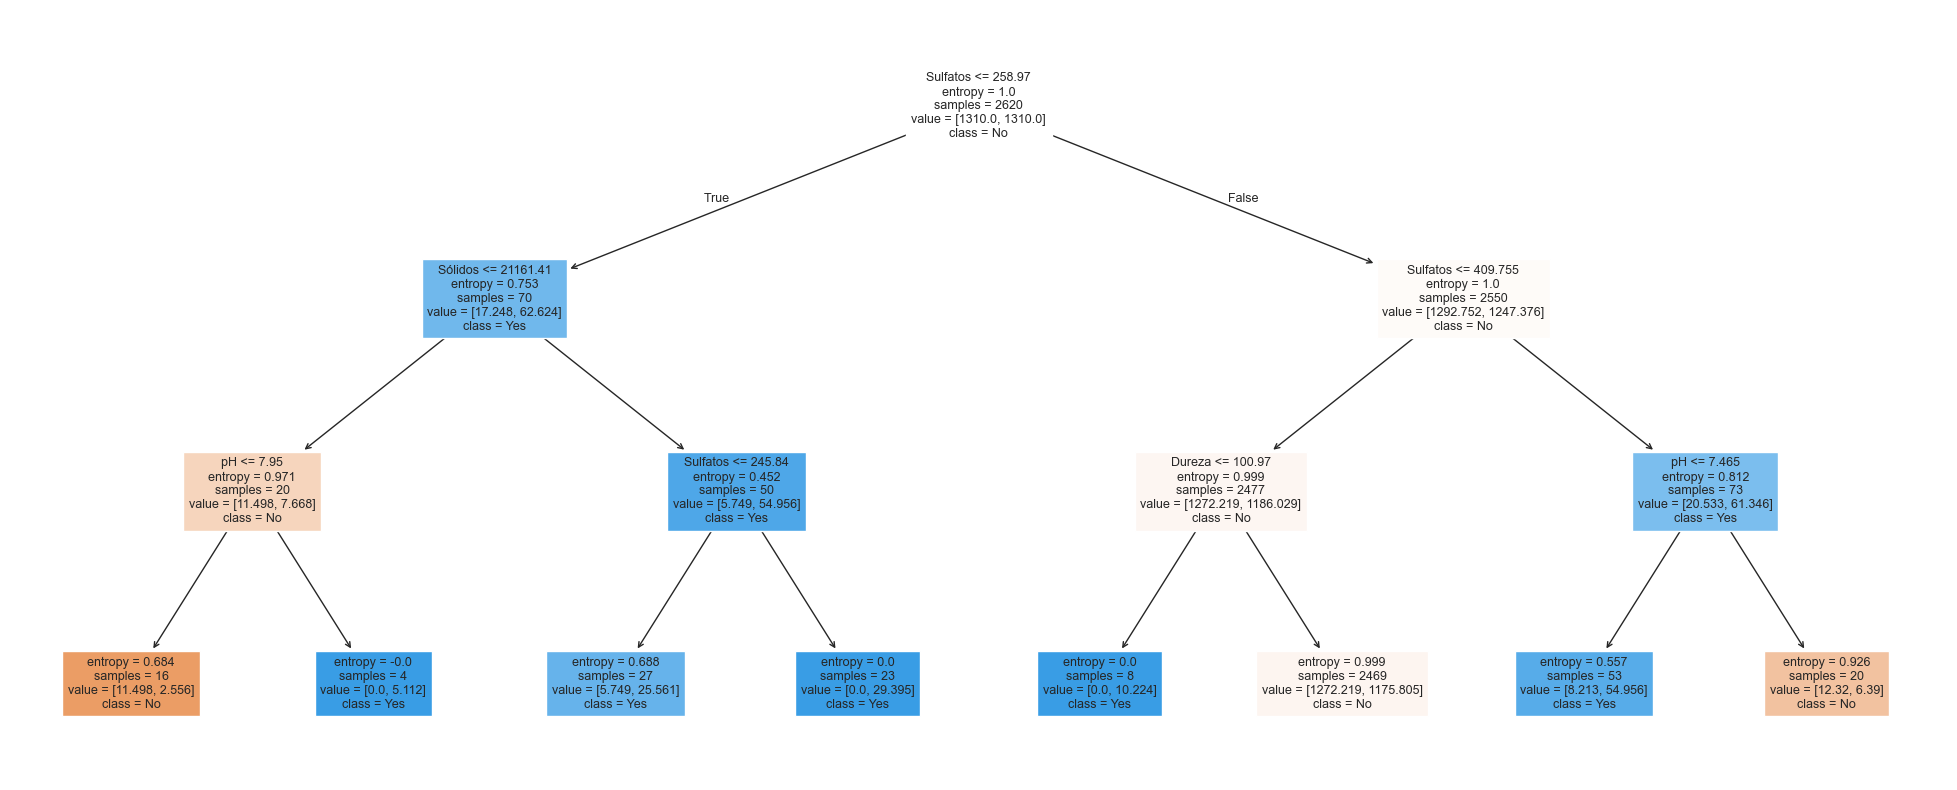

In [195]:
plt.figure(figsize=(25,10))
tree = plot_tree(new_mejor_modelo.named_steps['model'], feature_names=x_train.columns, class_names=['No','Yes'], filled=True, fontsize=9)

In [196]:

tree_rules = export_text(new_mejor_modelo.named_steps['model'], feature_names=columns)
print(tree_rules)

|--- Sulfatos <= 258.97
|   |--- Sólidos <= 21161.41
|   |   |--- pH <= 7.95
|   |   |   |--- class: 0
|   |   |--- pH >  7.95
|   |   |   |--- class: 1
|   |--- Sólidos >  21161.41
|   |   |--- Sulfatos <= 245.84
|   |   |   |--- class: 1
|   |   |--- Sulfatos >  245.84
|   |   |   |--- class: 1
|--- Sulfatos >  258.97
|   |--- Sulfatos <= 409.76
|   |   |--- Dureza <= 100.97
|   |   |   |--- class: 1
|   |   |--- Dureza >  100.97
|   |   |   |--- class: 0
|   |--- Sulfatos >  409.76
|   |   |--- pH <= 7.46
|   |   |   |--- class: 1
|   |   |--- pH >  7.46
|   |   |   |--- class: 0



CLONCLUSIONES Y RESPUESTA DE PREGUNTAS DE ANÁLISIS DE RESULTADOS
1. 